## Exploring datasets

### [street2shop](https://huggingface.co/datasets/petr7555/street2shop)

In [1]:
import datasets

# dataset = datasets.load_dataset('petr7555/street2shop')
# dataset.save_to_disk('street2shop')
dataset = datasets.load_from_disk('street2shop')
dataset['train'][0]

/home/yaseen/shoppin-assignment/virtual/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'type': 'train',
 'category': 'pants',
 'street_photo_id': 2470,
 'product_id': 804,
 'width': 1037.0,
 'top': 3091.0,
 'height': 2132.0,
 'left': 1267.0,
 'shop_photo_id': 20960,
 'street_photo_url': 'http://media1.modcloth.com/community_outfit_image/000/000/105/032/img_full_711c2659889c.jpg',
 'shop_photo_url': 'https://modcloth-production-media.s3.amazonaws.com/productshots/0131/9685/8aafc8ec23dfeffc003e3cd26c65303b.jpg?1376513652',
 'street_photo_image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3840x5760>,
 'shop_photo_image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=913x1304>}

In [2]:
# Get a sample image and its bounding box coordinates
sample = dataset['train'][0]
street_image = sample['street_photo_image']
shop_image = sample['shop_photo_image']
left = int(sample['left'])
top = int(sample['top']) 
width = int(sample['width'])
height = int(sample['height'])

# Crop the image using the bounding box coordinates
cropped_image = street_image.crop((left, top, left + width, top + height))

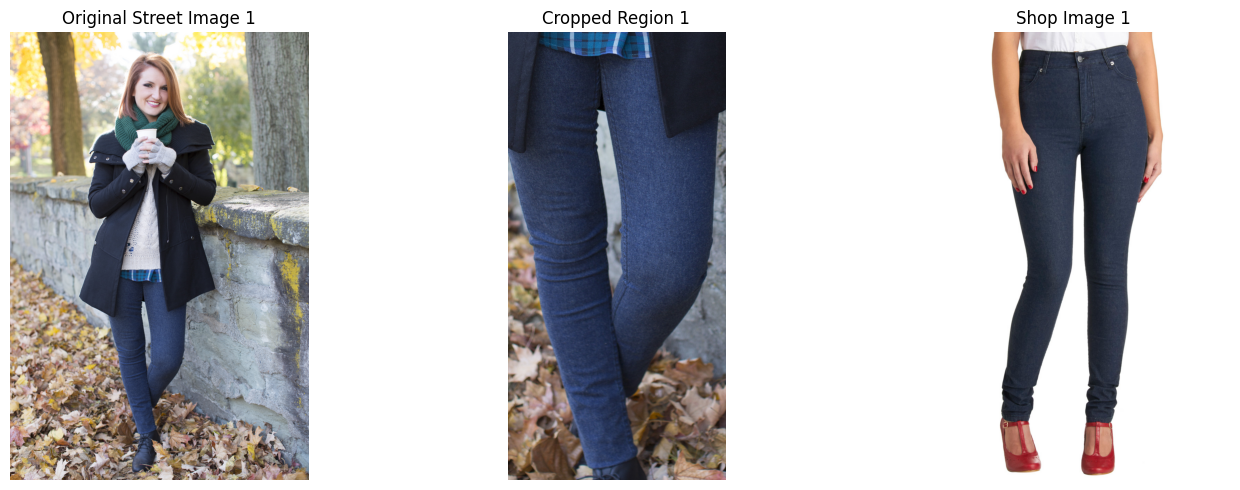

In [3]:
# Display original street image, cropped region, and shop image
import matplotlib.pyplot as plt

def display_images(street_images, cropped_images, shop_images):
    num_samples = len(street_images)
    plt.figure(figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Street image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(street_images[i])
        plt.title(f'Original Street Image {i+1}')
        plt.axis('off')
        
        # Cropped image
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(cropped_images[i])
        plt.title(f'Cropped Region {i+1}')
        plt.axis('off')
        
        # Shop image
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(shop_images[i])
        plt.title(f'Shop Image {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Convert single images to lists for backwards compatibility
display_images([street_image], [cropped_image], [shop_image])

In [4]:
from collections import Counter

print(Counter(dataset['train']['category']))
print(Counter(dataset['test']['category']))

Counter({'dresses': 44786, 'footwear': 23321, 'skirts': 8387, 'tops': 7123, 'leggings': 3759, 'outerwear': 3751, 'bags': 2307, 'pants': 1785, 'eyewear': 977, 'hats': 771, 'belts': 470})
Counter({'dresses': 12114, 'footwear': 7559, 'tops': 2427, 'skirts': 1585, 'outerwear': 1224, 'leggings': 1082, 'bags': 670, 'pants': 265, 'eyewear': 185, 'hats': 138, 'belts': 108})


In [5]:
print(len(dataset['train']))
print(len(dataset['test']))

97437
27357


In [6]:
# Get all column names
columns = dataset['train'].column_names

# For each column, print number of unique values
for column in columns:
    if column not in ['street_photo_image', 'shop_photo_image']:  # Skip image columns
        unique_count = len(set(dataset['train'][column]))
        print(f"{column}: {unique_count} unique values")

type: 1 unique values
category: 11 unique values
street_photo_id: 13202 unique values
product_id: 6893 unique values
width: 1845 unique values
top: 3163 unique values
height: 2446 unique values
left: 1997 unique values
shop_photo_id: 30428 unique values
street_photo_url: 13202 unique values
shop_photo_url: 30428 unique values


In [7]:
from torch.utils.data import Dataset
import random
import pandas as pd


class ImageSimilarityDataset(Dataset):
    def __init__(self, dataset, transform=None):
        # Convert dataset from columnar to record format
        self.dataset = pd.DataFrame(dataset).to_dict('records')
        self.transform = transform
        
        # Group images by category for efficient negative sampling
        self.category_groups = {}
        for idx in range(len(self.dataset)):
            category = self.dataset[idx]['category']
            if category not in self.category_groups:
                self.category_groups[category] = []
            self.category_groups[category].append(idx)
            
        # Create expanded dataset with positive and negative pairs
        self.pairs = []
        for idx in range(len(self.dataset)):
            # Add positive pair
            self.pairs.append((idx, idx, 1))
            
            # Add negative pairs (same category, different items)
            category = self.dataset[idx]['category']
            category_indices = self.category_groups[category]
            
            # Sample a few negative pairs per positive pair
            num_negatives = 2  # Can be adjusted
            neg_count = 0
            attempts = 0
            while neg_count < num_negatives and attempts < 10:
                neg_idx = random.choice(category_indices)
                neg_item = self.dataset[neg_idx]
                anchor_item = self.dataset[idx]
                
                # Check if it's a different item
                if (
                    neg_item['street_photo_url'] != anchor_item['street_photo_url'] or
                    neg_item['left'] != anchor_item['left'] or
                    neg_item['top'] != anchor_item['top'] or
                    neg_item['width'] != anchor_item['width'] or
                    neg_item['height'] != anchor_item['height']
                ):
                    self.pairs.append((idx, neg_idx, -1))
                    neg_count += 1
                attempts += 1
            
    def __len__(self):
        return len(self.pairs)
    
    def get_cropped_image(self, idx):
        item = self.dataset[idx]
        street_img = item['street_photo_image']
        left = int(item['left'])
        top = int(item['top'])
        width = int(item['width'])
        height = int(item['height'])
        return street_img.crop((left, top, left + width, top + height))
    
    def __getitem__(self, idx):
        street_idx, shop_idx, label = self.pairs[idx]
        
        # Get street (cropped) and shop images
        street_img = self.get_cropped_image(street_idx)
        shop_img = self.dataset[shop_idx]['shop_photo_image']
        
        # Apply transforms if specified
        if self.transform:
            street_img = self.transform(street_img)
            shop_img = self.transform(shop_img)
            
        return street_img, shop_img, label

# Example usage:
# train_dataset = ImageSimilarityDataset(dataset['train'], transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [8]:
# assert False
type(dataset)
dataset.keys()

dict_keys(['test', 'train'])

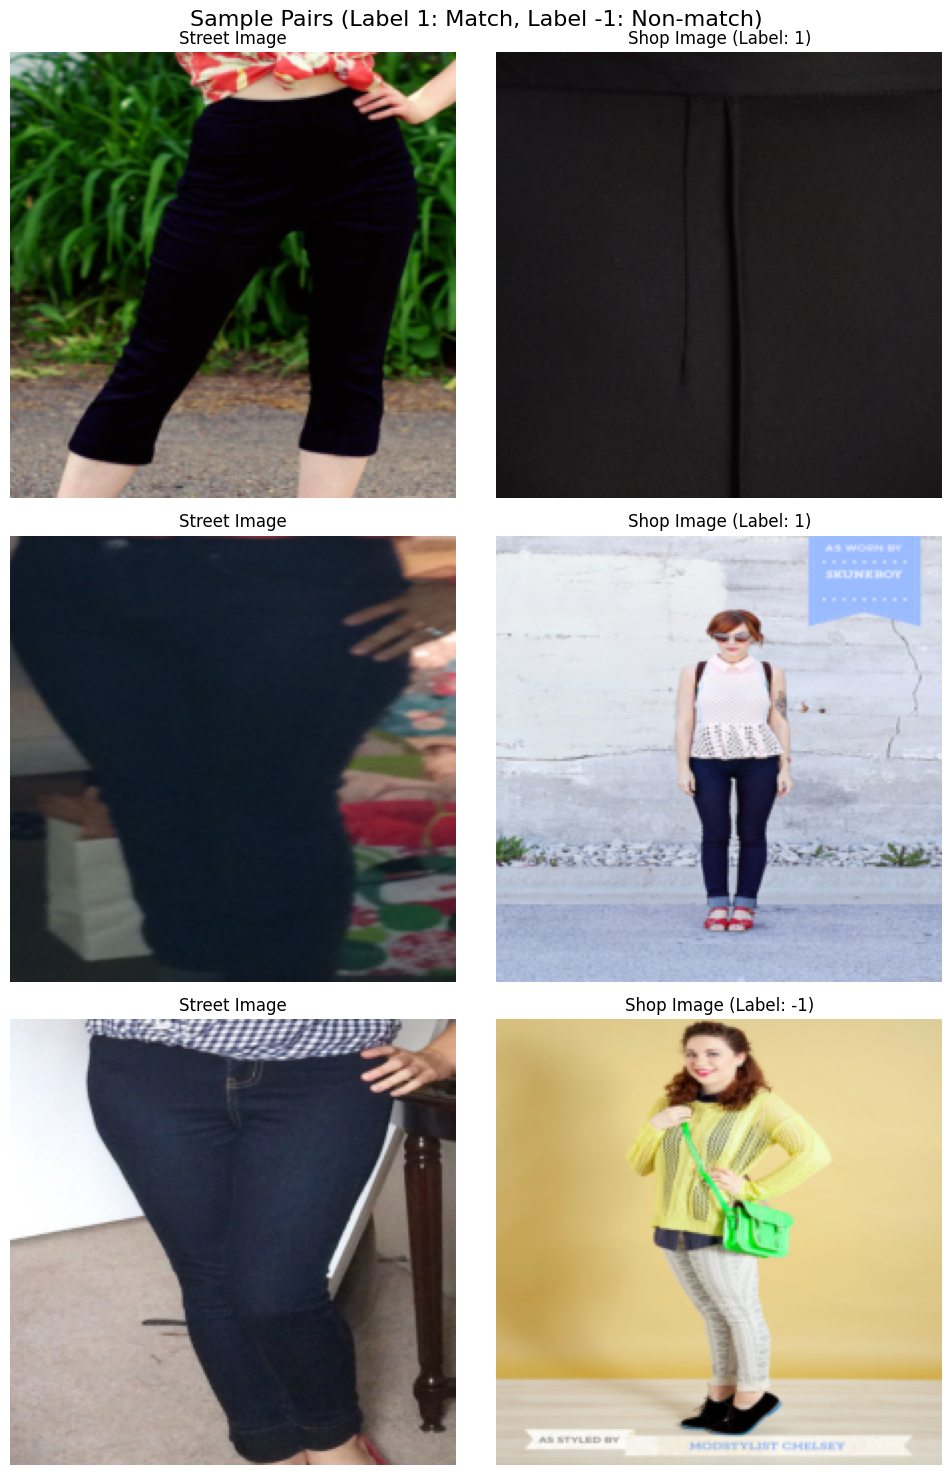

In [9]:
# Sample and display some pairs with their labels
import matplotlib.pyplot as plt
import random
from torchvision import transforms

# Create a dataset instance with some basic transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = dataset['train'][:100]

dataset_instance = ImageSimilarityDataset(dataset, transform=transform)

# Sample a few random pairs
num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
fig.suptitle('Sample Pairs (Label 1: Match, Label -1: Non-match)', fontsize=16)

for i in range(num_samples):
    # Get a random sample
    idx = random.randint(0, len(dataset_instance)-1)
    street_img, shop_img, label = dataset_instance[idx]
    
    # Convert tensors back to images for display
    street_img = transforms.ToPILImage()(street_img)
    shop_img = transforms.ToPILImage()(shop_img)
    
    # Plot the pair
    axes[i,0].imshow(street_img)
    axes[i,0].set_title('Cropped Street Image')
    axes[i,0].axis('off')
    
    axes[i,1].imshow(shop_img)
    axes[i,1].set_title(f'Shop Image (Label: {label})')
    axes[i,1].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# # Quick PyTorch test
# import torch

# # Create a small tensor
# x = torch.rand(5, 3)
# print("Random tensor:")
# print(x)

# # Basic operation
# y = x + 2
# print("\nTensor + 2:")
# print(y)

# # Check if CUDA is available
# print("\nCUDA available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("Current CUDA device:", torch.cuda.current_device())
#     print("CUDA device name:", torch.cuda.get_device_name(0))


: 

### [DeepFashion - Consumer-to-shop](https://mmlab.ie.cuhk.edu.hk/projects/DeepFashion/Consumer2ShopRetrieval.html)